In [166]:
import os
import sys
import torch
from dotenv import load_dotenv

In [167]:
load_dotenv()

True

In [168]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import gdown
from typing import List

In [169]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_per_process_memory_fraction(0.9, device=torch.cuda.current_device())
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
print("Using device: ", device)

Using device:  cuda


Data Ingestion:

In [170]:
TRAINING_FILE = os.getenv('TRAINING_FILE')

In [171]:
output = 'training_data.zip'
gdown.download(TRAINING_FILE, output, quiet=False)
gdown.extractall(output, '../data/raw')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=3494d9e4-d18e-4c4e-955e-20409cd550d7
To: c:\Users\ABHINAV\Desktop\Prog\Projects\LipNet\notebooks\training_data.zip
100%|██████████| 423M/423M [00:33<00:00, 12.5MB/s] 


['../data/raw\\data/',
 '../data/raw\\data/alignments/',
 '../data/raw\\data/alignments/s1/',
 '../data/raw\\data/alignments/s1/bbaf2n.align',
 '../data/raw\\data/alignments/s1/bbaf3s.align',
 '../data/raw\\data/alignments/s1/bbaf4p.align',
 '../data/raw\\data/alignments/s1/bbaf5a.align',
 '../data/raw\\data/alignments/s1/bbal6n.align',
 '../data/raw\\data/alignments/s1/bbal7s.align',
 '../data/raw\\data/alignments/s1/bbal8p.align',
 '../data/raw\\data/alignments/s1/bbal9a.align',
 '../data/raw\\data/alignments/s1/bbas1s.align',
 '../data/raw\\data/alignments/s1/bbas2p.align',
 '../data/raw\\data/alignments/s1/bbas3a.align',
 '../data/raw\\data/alignments/s1/bbaszn.align',
 '../data/raw\\data/alignments/s1/bbaz4n.align',
 '../data/raw\\data/alignments/s1/bbaz5s.align',
 '../data/raw\\data/alignments/s1/bbaz6p.align',
 '../data/raw\\data/alignments/s1/bbaz7a.align',
 '../data/raw\\data/alignments/s1/bbbf6n.align',
 '../data/raw\\data/alignments/s1/bbbf7s.align',
 '../data/raw\\data/alig

In [172]:
def video_loader(path : str) -> List[torch.Tensor]:
    cap = cv2.VideoCapture(path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret: 
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame[190:236, 80:220]
        frames.append(torch.tensor(frame, dtype=torch.float32)/255.0)

    cap.release()

    video_tensor = torch.stack(frames)
    mean = video_tensor.mean()
    std = video_tensor.std()
    norm = (video_tensor - mean)/std
    return norm

In [173]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [174]:
cTn = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, oov_token="")
nTc = tf.keras.layers.StringLookup(
    vocabulary = cTn.get_vocabulary(), oov_token="", invert=True
)

In [175]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_idx = {ch: i+1 for i, ch in enumerate(vocab)}  
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

In [176]:
def string_to_tensor(s: str) -> torch.Tensor:
    indices = [char_to_idx.get(ch, 0) for ch in s.lower()]
    return torch.tensor(indices, dtype=torch.long)
def tensor_to_string(t: torch.Tensor) -> str:
    return ''.join([idx_to_char.get(idx.item(), '') for idx in t])

In [177]:
def alignment_loader(path: str) -> torch.Tensor:
    with open(path) as f:
        lines = f.readlines()
    tokens = ''
    for line in lines:
        if 'sil' != line.split()[2]:
            tokens += ' ' + line.split()[2]
    tokens = tokens.strip()
    return string_to_tensor(tokens)

In [178]:
def load_data(path: str):
    if isinstance(path, torch.Tensor):
        path = path.item() if path.dim() == 0 else path.tolist()
    if isinstance(path, bytes):
        path = path.decode()

    file_name = os.path.basename(path).split('.')[0]
    video_path = os.path.join('../data/raw/train_data', 's1', f'{file_name}.mpg').replace("\\", "/")
    align_path = os.path.join('../data/raw/train_data', 'alignments', 's1', f'{file_name}.align').replace("\\", "/")

    frames = video_loader(video_path)
    aligns = alignment_loader(align_path)
    return frames, aligns

In [188]:
test_path = '../data/raw/train_data/s1/swiozn.mpg'
frames, aligns = load_data(test_path)
print("Frames shape: ", frames.shape)
print("Aligns shape: ", aligns.shape)

Frames shape:  torch.Size([75, 46, 140])
Aligns shape:  torch.Size([23])


In [189]:
frames

tensor([[[ 0.2281,  0.2281,  0.2281,  ...,  1.1082,  1.0244,  0.8986],
         [ 0.2281,  0.2281,  0.2281,  ...,  1.1082,  1.0244,  0.8986],
         [ 0.1861,  0.1861,  0.1861,  ...,  1.0244,  0.9824,  0.8986],
         ...,
         [-0.1491, -0.1491, -0.1491,  ...,  1.1920,  1.3177,  0.4376],
         [-0.1910, -0.1910, -0.1910,  ...,  1.2339,  1.1082,  1.1920],
         [-0.1910, -0.1910, -0.1910,  ...,  1.3177,  1.0663,  1.5273]],

        [[ 0.1861,  0.1861,  0.1861,  ...,  1.0663,  0.9824,  0.8986],
         [ 0.1861,  0.1861,  0.1861,  ...,  1.0663,  0.9824,  0.9824],
         [ 0.1442,  0.1442,  0.1442,  ...,  1.0244,  0.9824,  0.8986],
         ...,
         [-0.1072, -0.1072, -0.1491,  ...,  1.3596,  1.3596,  0.5633],
         [-0.1491, -0.1491, -0.1910,  ...,  1.4016,  1.2339,  1.3177],
         [-0.1491, -0.1491, -0.1910,  ...,  1.2339,  1.2339,  1.4854]],

        [[ 0.1861,  0.1861,  0.1861,  ...,  1.0663,  0.9824,  0.9824],
         [ 0.1861,  0.1861,  0.1861,  ...,  1

In [190]:
aligns

tensor([19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39, 15, 39, 26,  5, 18,
        15, 39, 14, 15, 23])

In [191]:
print("Decoded:",tensor_to_string(aligns))

Decoded: set white in o zero now


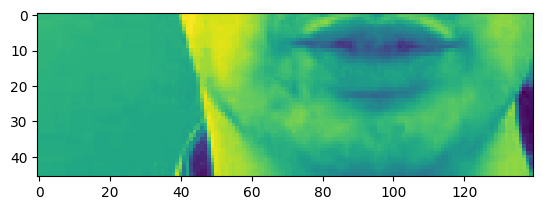

In [205]:
plt.imshow(frames[42])